In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms

import matplotlib.pyplot as plt



In [38]:
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

class MLP_MNIST(nn.Module):
    
    def __init__(self,dims,outsize,dropout=[0.0,0.0]):
        super(MLP_MNIST,self).__init__()
        self.fc1 = nn.Linear(dims[0],dims[1])
        self.dropout1 = nn.Dropout(p=dropout[0])
        self.fc2 = nn.Linear(dims[1],dims[2])
        self.dropout2 = nn.Dropout(p=dropout[1])
        self.fc3 = nn.Linear(dims[2],outsize)
        
        self.insize = dims[0]
        
    def forward(self,x):
        a1 = self.fc1(x)
        d1 = self.dropout1(a1)
        h1 = nn.functional.relu(d1)
        
        a2 = self.fc2(h1)
        d2 = self.dropout2(a2)
        h2 = nn.functional.relu(d2)
        
        logits = self.fc3(h2)
        
        return logits
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices


In [49]:
def init_train(model,traindata,lr,batch_size):
    print model
    trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
    loss_crit = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
    NUMEPOCHS=10
    epoch_loss= [0]*NUMEPOCHS
    for epoch in range(NUMEPOCHS):
        losses = []
        for batch_index, (inputs, targets) in enumerate(trainloader):
            x, targets = Variable(inputs.view([-1,28*28])), Variable(targets)

            logits = model.forward(x)
    
            loss = loss_crit(logits,targets)
            loss.backward()
            optimizer.step()

            losses.append(loss.data[0])
        epoch_loss[epoch] = np.mean(losses)
        print('Epoch : %d Loss : %.3f ' % (epoch+1, np.mean(losses)))
    return epoch_loss

#Initializes using Glorot Initialization
def GlorotInitialize(model):
    #Initialize parameters
    params = list(model.parameters())

    for p in params:
        if len(p.size()) > 1:
            dl = np.sqrt(6.0/(p.size()[0]+p.size()[1]))
            nn.init.uniform(p,-dl,dl)
        else:
            nn.init.uniform(p,0,0)
            
    return model

MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=200)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=200, out_features=10)
)
Epoch : 1 Loss : 2.302 
Epoch : 2 Loss : 2.302 
Epoch : 3 Loss : 2.301 
Epoch : 4 Loss : 2.301 
Epoch : 5 Loss : 2.302 
Epoch : 6 Loss : 2.302 
Epoch : 7 Loss : 2.302 
Epoch : 8 Loss : 2.302 
Epoch : 9 Loss : 2.302 
Epoch : 10 Loss : 2.301 
MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=200)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=200, out_features=10)
)
Epoch : 1 Loss : 1050.231 
Epoch : 2 Loss : 304.082 
Epoch : 3 Loss : 156.016 
Epoch : 4 Loss : 91.700 
Epoch : 5 Loss : 60.506 
Epoch : 6 Loss : 37.046 
Epoch : 7 Loss : 18.285 
Epoch : 8 Loss : 5.653 
Epoch : 9 Loss : 3.192 
Epoch : 10 Loss : 2.405 
MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)

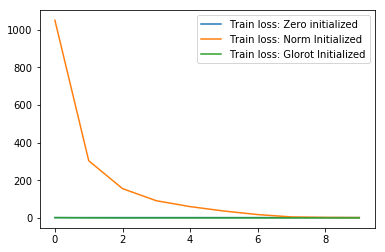

In [52]:
#Zero Weight Initialization
lr=1e-5
ZeroInitNet = MLP_MNIST([28*28,500,200],10)
params = list(ZeroInitNet.parameters())
for p in params:
    nn.init.uniform(p,0,0)
    
zero_losses = init_train(ZeroInitNet,mnist_train,lr,128)

lr=1e-6
NormInitNet = MLP_MNIST([28*28,500,200],10)
params = list(NormInitNet.parameters())
for p in params:
    if len(p.size()) > 1:
        nn.init.normal(p,0,1)
    else:
        nn.init.uniform(p,0,0)
norm_losses = init_train(NormInitNet,mnist_train,lr,128)

lr=1e-5
GlorotInitNet = MLP_MNIST([28*28,500,200],10)
GlorotInit_Net = GlorotInitialize(GlorotInitNet)
glorot_losses = init_train(GlorotInit_Net,mnist_train,lr,128)

plt.plot(zero_losses,label='Train loss: Zero initialized ')
plt.plot(norm_losses,label='Train loss: Norm Initialized')
plt.plot(glorot_losses,label='Train loss: Glorot Initialized')
plt.legend()
plt.show()
    

# Initialization Comments

First it should be noted that 

# Learning Curves

In [65]:
#returns the best instance in training of the model to be trained as well as the loss and accuracy
#for both train and val if available.
def train(model, num_epochs,trainLoader,optimizer,valLoader=None, testLoader = None):
    bestValAcc = 0
    bestNetwork = 0
    train_accuracy = []
    val_accuracy = []
    test_accuracy = []
    epoch_loss=[0]*num_epochs
    for epoch in range(num_epochs):
        losses = []
        correct = 0
        total = 0
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        model.train()
        for batch_index, (inputs, targets) in enumerate(trainLoader):
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
            _, preds = model.prediction(logits)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
            loss = loss_crit(logits,targets)

            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
        epoch_loss[epoch] = np.mean(losses)
        train_accuracy.append(correct/float(total))
        
        if (valLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(valLoader):
                x, targets = Variable(inputs.view([-1,28*28])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                val_correct += preds.eq(targets.data).sum()
                val_total += targets.size(0)
            val_acc = (val_correct/float(val_total))
            val_accuracy.append(val_acc)
                            
            if val_acc > bestValAcc:
                bestNetwork = model
                bestValAcc= val_acc
                
        if (testLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(testLoader):
                x, targets = Variable(inputs.view([-1,28*28])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                test_correct += preds.eq(targets.data).sum()
                test_total += targets.size(0)
            test_acc = (val_correct/float(val_total))
            test_accuracy.append(val_acc)
            
        if (valLoader != None and testLoader != None):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch], train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
        elif (valLoader != None and testLoader == None):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch], train_accuracy[epoch], val_accuracy[epoch]))
        else:
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
    return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy)
    

            
def hyperparamsearch(num_epochs, hparams, trainLoader, valLoader = None, testLoader = None ):
    bestNetwork = 0
    bestValAcc = 0
    for layer in hparams['layers']:
        for lr in hparams['lr']:
            for decay in hparams['lr_decay']:
                for drop in hparams['dropout']:
                    print "Neural Net Hyper params:"
                    print "Layers: " + repr(layer)
                    print "Learning Rate: " + repr(lr)
                    print "Learning rate decay: " + repr(decay)
                    print "Dropout rate Layer 1:" + repr(drop[0]) + ", Layer 2: " + repr(drop[1])
                    epoch_loss = [0] * num_epochs
                    NeuralNet = MLP_MNIST(layer,10,drop)
                    NeuralNet = GlorotInitialize(NeuralNet)
                    optimizer = torch.optim.Adagrad(NeuralNet.parameters(), lr=lr,lr_decay = decay)

                    
                    network, loss_history, train_accuracy, val_accuracy,test_accuracy = train(NeuralNet,num_epochs, trainLoader,optimizer,valLoader)
                    if (max(val_accuracy) > bestValAcc):
                        bestNetwork = network
                        bestValAcc = max(val_accuracy)
                    plt.plot(train_accuracy)
                    if (valLoader != None):
                        plt.plot(val_accuracy)
                    if (testLoader != None):
                        plt.plot(test_accuracy)
                    plt.show()
                    
    return bestNetwork

In [66]:
#Learning Curves
#Split training data into test and train
TRAINSIZE = 50000
indices = list(range(TRAINSIZE))
val_percent = 0.2
split = int((1-val_percent)*TRAINSIZE)
np.random.shuffle(indices)
train_idx, valid_idx = indices[:split], indices[split:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, sampler=train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, sampler=valid_sampler, num_workers=2)

testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)



Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 0.0001
Learning rate decay: 1e-06
Dropout rate Layer 1:0.2, Layer 2: 0.2
Epoch : 1 Loss : 1.132  Train Accuracy: 0.725 Validation Accuracy: 0.854
Epoch : 2 Loss : 0.519  Train Accuracy: 0.846 Validation Accuracy: 0.884
Epoch : 3 Loss : 0.411  Train Accuracy: 0.875 Validation Accuracy: 0.900
Epoch : 4 Loss : 0.363  Train Accuracy: 0.892 Validation Accuracy: 0.910
Epoch : 5 Loss : 0.327  Train Accuracy: 0.905 Validation Accuracy: 0.918
Epoch : 6 Loss : 0.298  Train Accuracy: 0.912 Validation Accuracy: 0.924
Epoch : 7 Loss : 0.274  Train Accuracy: 0.918 Validation Accuracy: 0.930
Epoch : 8 Loss : 0.257  Train Accuracy: 0.924 Validation Accuracy: 0.933
Epoch : 9 Loss : 0.245  Train Accuracy: 0.926 Validation Accuracy: 0.936
Epoch : 10 Loss : 0.230  Train Accuracy: 0.931 Validation Accuracy: 0.937
Epoch : 11 Loss : 0.217  Train Accuracy: 0.935 Validation Accuracy: 0.940
Epoch : 12 Loss : 0.207  Train Accuracy: 0.937 Validation 

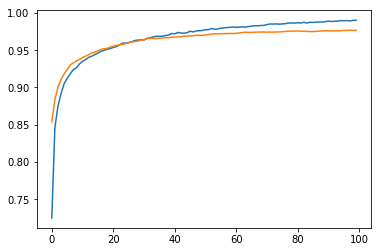

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 0.0001
Learning rate decay: 1e-06
Dropout rate Layer 1:0.15, Layer 2: 0.15
Epoch : 1 Loss : 1.087  Train Accuracy: 0.737 Validation Accuracy: 0.857
Epoch : 2 Loss : 0.500  Train Accuracy: 0.852 Validation Accuracy: 0.884
Epoch : 3 Loss : 0.406  Train Accuracy: 0.878 Validation Accuracy: 0.901
Epoch : 4 Loss : 0.356  Train Accuracy: 0.895 Validation Accuracy: 0.911
Epoch : 5 Loss : 0.326  Train Accuracy: 0.904 Validation Accuracy: 0.917
Epoch : 6 Loss : 0.300  Train Accuracy: 0.912 Validation Accuracy: 0.921
Epoch : 7 Loss : 0.278  Train Accuracy: 0.916 Validation Accuracy: 0.926
Epoch : 8 Loss : 0.261  Train Accuracy: 0.922 Validation Accuracy: 0.931
Epoch : 9 Loss : 0.245  Train Accuracy: 0.927 Validation Accuracy: 0.935
Epoch : 10 Loss : 0.230  Train Accuracy: 0.931 Validation Accuracy: 0.939
Epoch : 11 Loss : 0.217  Train Accuracy: 0.936 Validation Accuracy: 0.942
Epoch : 12 Loss : 0.208  Train Accuracy: 0.939 Validatio

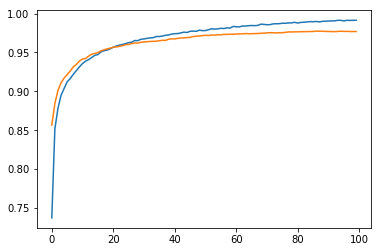

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 0.0001
Learning rate decay: 1e-06
Dropout rate Layer 1:0.1, Layer 2: 0.1
Epoch : 1 Loss : 1.028  Train Accuracy: 0.756 Validation Accuracy: 0.859
Epoch : 2 Loss : 0.469  Train Accuracy: 0.863 Validation Accuracy: 0.888
Epoch : 3 Loss : 0.376  Train Accuracy: 0.888 Validation Accuracy: 0.901
Epoch : 4 Loss : 0.335  Train Accuracy: 0.901 Validation Accuracy: 0.912
Epoch : 5 Loss : 0.305  Train Accuracy: 0.910 Validation Accuracy: 0.917
Epoch : 6 Loss : 0.283  Train Accuracy: 0.917 Validation Accuracy: 0.924
Epoch : 7 Loss : 0.263  Train Accuracy: 0.924 Validation Accuracy: 0.927
Epoch : 8 Loss : 0.246  Train Accuracy: 0.927 Validation Accuracy: 0.931
Epoch : 9 Loss : 0.230  Train Accuracy: 0.931 Validation Accuracy: 0.933
Epoch : 10 Loss : 0.219  Train Accuracy: 0.935 Validation Accuracy: 0.937
Epoch : 11 Loss : 0.210  Train Accuracy: 0.937 Validation Accuracy: 0.941
Epoch : 12 Loss : 0.199  Train Accuracy: 0.941 Validation 

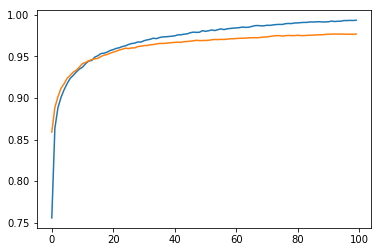

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 0.0001
Learning rate decay: 1e-05
Dropout rate Layer 1:0.2, Layer 2: 0.2
Epoch : 1 Loss : 1.128  Train Accuracy: 0.715 Validation Accuracy: 0.850
Epoch : 2 Loss : 0.531  Train Accuracy: 0.843 Validation Accuracy: 0.883
Epoch : 3 Loss : 0.422  Train Accuracy: 0.871 Validation Accuracy: 0.900
Epoch : 4 Loss : 0.376  Train Accuracy: 0.888 Validation Accuracy: 0.909
Epoch : 5 Loss : 0.338  Train Accuracy: 0.900 Validation Accuracy: 0.915
Epoch : 6 Loss : 0.309  Train Accuracy: 0.908 Validation Accuracy: 0.922
Epoch : 7 Loss : 0.286  Train Accuracy: 0.915 Validation Accuracy: 0.927
Epoch : 8 Loss : 0.266  Train Accuracy: 0.920 Validation Accuracy: 0.932
Epoch : 9 Loss : 0.254  Train Accuracy: 0.924 Validation Accuracy: 0.935
Epoch : 10 Loss : 0.240  Train Accuracy: 0.929 Validation Accuracy: 0.937
Epoch : 11 Loss : 0.228  Train Accuracy: 0.932 Validation Accuracy: 0.940
Epoch : 12 Loss : 0.219  Train Accuracy: 0.935 Validation 

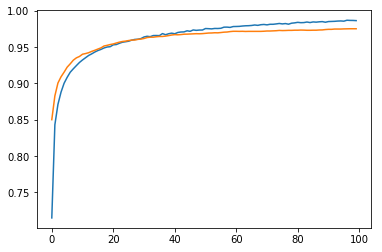

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 0.0001
Learning rate decay: 1e-05
Dropout rate Layer 1:0.15, Layer 2: 0.15
Epoch : 1 Loss : 1.077  Train Accuracy: 0.728 Validation Accuracy: 0.858
Epoch : 2 Loss : 0.489  Train Accuracy: 0.856 Validation Accuracy: 0.890
Epoch : 3 Loss : 0.392  Train Accuracy: 0.882 Validation Accuracy: 0.902
Epoch : 4 Loss : 0.349  Train Accuracy: 0.897 Validation Accuracy: 0.912
Epoch : 5 Loss : 0.318  Train Accuracy: 0.906 Validation Accuracy: 0.919
Epoch : 6 Loss : 0.291  Train Accuracy: 0.914 Validation Accuracy: 0.925
Epoch : 7 Loss : 0.272  Train Accuracy: 0.919 Validation Accuracy: 0.931
Epoch : 8 Loss : 0.254  Train Accuracy: 0.924 Validation Accuracy: 0.934
Epoch : 9 Loss : 0.239  Train Accuracy: 0.929 Validation Accuracy: 0.937
Epoch : 10 Loss : 0.228  Train Accuracy: 0.931 Validation Accuracy: 0.939
Epoch : 11 Loss : 0.218  Train Accuracy: 0.936 Validation Accuracy: 0.941
Epoch : 12 Loss : 0.206  Train Accuracy: 0.939 Validatio

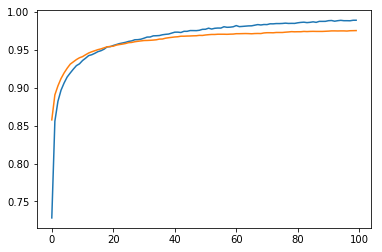

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 0.0001
Learning rate decay: 1e-05
Dropout rate Layer 1:0.1, Layer 2: 0.1
Epoch : 1 Loss : 1.061  Train Accuracy: 0.754 Validation Accuracy: 0.859
Epoch : 2 Loss : 0.471  Train Accuracy: 0.864 Validation Accuracy: 0.888
Epoch : 3 Loss : 0.380  Train Accuracy: 0.887 Validation Accuracy: 0.902
Epoch : 4 Loss : 0.336  Train Accuracy: 0.900 Validation Accuracy: 0.909
Epoch : 5 Loss : 0.309  Train Accuracy: 0.909 Validation Accuracy: 0.918
Epoch : 6 Loss : 0.285  Train Accuracy: 0.916 Validation Accuracy: 0.925
Epoch : 7 Loss : 0.270  Train Accuracy: 0.921 Validation Accuracy: 0.930
Epoch : 8 Loss : 0.250  Train Accuracy: 0.926 Validation Accuracy: 0.932
Epoch : 9 Loss : 0.236  Train Accuracy: 0.930 Validation Accuracy: 0.935
Epoch : 10 Loss : 0.222  Train Accuracy: 0.935 Validation Accuracy: 0.938
Epoch : 11 Loss : 0.212  Train Accuracy: 0.937 Validation Accuracy: 0.940
Epoch : 12 Loss : 0.203  Train Accuracy: 0.938 Validation 

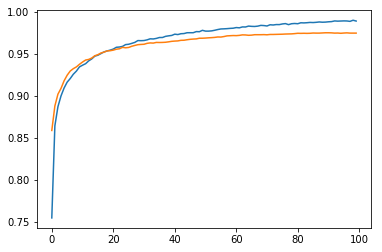

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 5e-05
Learning rate decay: 1e-06
Dropout rate Layer 1:0.2, Layer 2: 0.2
Epoch : 1 Loss : 1.656  Train Accuracy: 0.586 Validation Accuracy: 0.796
Epoch : 2 Loss : 1.038  Train Accuracy: 0.760 Validation Accuracy: 0.826
Epoch : 3 Loss : 0.770  Train Accuracy: 0.799 Validation Accuracy: 0.846
Epoch : 4 Loss : 0.631  Train Accuracy: 0.823 Validation Accuracy: 0.862
Epoch : 5 Loss : 0.555  Train Accuracy: 0.838 Validation Accuracy: 0.871
Epoch : 6 Loss : 0.500  Train Accuracy: 0.851 Validation Accuracy: 0.880
Epoch : 7 Loss : 0.468  Train Accuracy: 0.860 Validation Accuracy: 0.886
Epoch : 8 Loss : 0.441  Train Accuracy: 0.867 Validation Accuracy: 0.889
Epoch : 9 Loss : 0.422  Train Accuracy: 0.872 Validation Accuracy: 0.893
Epoch : 10 Loss : 0.403  Train Accuracy: 0.879 Validation Accuracy: 0.897
Epoch : 11 Loss : 0.390  Train Accuracy: 0.882 Validation Accuracy: 0.900
Epoch : 12 Loss : 0.376  Train Accuracy: 0.886 Validation A

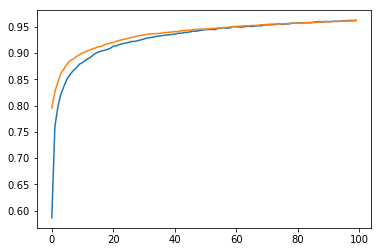

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 5e-05
Learning rate decay: 1e-06
Dropout rate Layer 1:0.15, Layer 2: 0.15
Epoch : 1 Loss : 1.624  Train Accuracy: 0.627 Validation Accuracy: 0.800
Epoch : 2 Loss : 0.980  Train Accuracy: 0.788 Validation Accuracy: 0.840
Epoch : 3 Loss : 0.710  Train Accuracy: 0.823 Validation Accuracy: 0.859
Epoch : 4 Loss : 0.577  Train Accuracy: 0.843 Validation Accuracy: 0.873
Epoch : 5 Loss : 0.503  Train Accuracy: 0.854 Validation Accuracy: 0.878
Epoch : 6 Loss : 0.457  Train Accuracy: 0.864 Validation Accuracy: 0.886
Epoch : 7 Loss : 0.426  Train Accuracy: 0.872 Validation Accuracy: 0.891
Epoch : 8 Loss : 0.403  Train Accuracy: 0.878 Validation Accuracy: 0.895
Epoch : 9 Loss : 0.385  Train Accuracy: 0.883 Validation Accuracy: 0.901
Epoch : 10 Loss : 0.373  Train Accuracy: 0.888 Validation Accuracy: 0.904
Epoch : 11 Loss : 0.359  Train Accuracy: 0.892 Validation Accuracy: 0.904
Epoch : 12 Loss : 0.348  Train Accuracy: 0.896 Validation

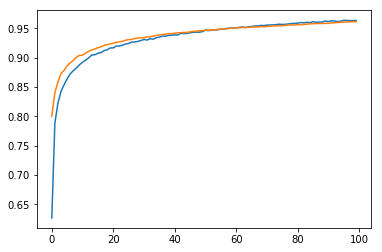

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 5e-05
Learning rate decay: 1e-06
Dropout rate Layer 1:0.1, Layer 2: 0.1
Epoch : 1 Loss : 1.581  Train Accuracy: 0.646 Validation Accuracy: 0.792
Epoch : 2 Loss : 0.948  Train Accuracy: 0.792 Validation Accuracy: 0.830
Epoch : 3 Loss : 0.689  Train Accuracy: 0.825 Validation Accuracy: 0.850
Epoch : 4 Loss : 0.561  Train Accuracy: 0.846 Validation Accuracy: 0.864
Epoch : 5 Loss : 0.486  Train Accuracy: 0.861 Validation Accuracy: 0.875
Epoch : 6 Loss : 0.443  Train Accuracy: 0.869 Validation Accuracy: 0.884
Epoch : 7 Loss : 0.412  Train Accuracy: 0.878 Validation Accuracy: 0.891
Epoch : 8 Loss : 0.389  Train Accuracy: 0.884 Validation Accuracy: 0.895
Epoch : 9 Loss : 0.374  Train Accuracy: 0.888 Validation Accuracy: 0.899
Epoch : 10 Loss : 0.363  Train Accuracy: 0.891 Validation Accuracy: 0.901
Epoch : 11 Loss : 0.349  Train Accuracy: 0.896 Validation Accuracy: 0.903
Epoch : 12 Loss : 0.337  Train Accuracy: 0.899 Validation A

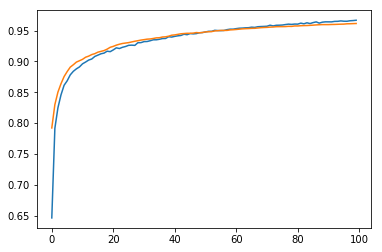

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 5e-05
Learning rate decay: 1e-05
Dropout rate Layer 1:0.2, Layer 2: 0.2
Epoch : 1 Loss : 1.609  Train Accuracy: 0.619 Validation Accuracy: 0.801
Epoch : 2 Loss : 1.008  Train Accuracy: 0.768 Validation Accuracy: 0.838
Epoch : 3 Loss : 0.755  Train Accuracy: 0.800 Validation Accuracy: 0.853
Epoch : 4 Loss : 0.627  Train Accuracy: 0.823 Validation Accuracy: 0.867
Epoch : 5 Loss : 0.551  Train Accuracy: 0.837 Validation Accuracy: 0.875
Epoch : 6 Loss : 0.500  Train Accuracy: 0.851 Validation Accuracy: 0.883
Epoch : 7 Loss : 0.465  Train Accuracy: 0.859 Validation Accuracy: 0.889
Epoch : 8 Loss : 0.444  Train Accuracy: 0.863 Validation Accuracy: 0.893
Epoch : 9 Loss : 0.419  Train Accuracy: 0.872 Validation Accuracy: 0.895
Epoch : 10 Loss : 0.402  Train Accuracy: 0.878 Validation Accuracy: 0.897
Epoch : 11 Loss : 0.393  Train Accuracy: 0.880 Validation Accuracy: 0.901
Epoch : 12 Loss : 0.376  Train Accuracy: 0.884 Validation A

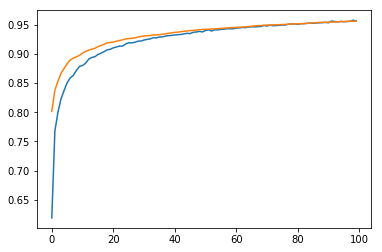

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 5e-05
Learning rate decay: 1e-05
Dropout rate Layer 1:0.15, Layer 2: 0.15
Epoch : 1 Loss : 1.620  Train Accuracy: 0.627 Validation Accuracy: 0.798
Epoch : 2 Loss : 0.995  Train Accuracy: 0.784 Validation Accuracy: 0.836
Epoch : 3 Loss : 0.733  Train Accuracy: 0.815 Validation Accuracy: 0.855
Epoch : 4 Loss : 0.599  Train Accuracy: 0.835 Validation Accuracy: 0.866
Epoch : 5 Loss : 0.520  Train Accuracy: 0.851 Validation Accuracy: 0.876
Epoch : 6 Loss : 0.474  Train Accuracy: 0.861 Validation Accuracy: 0.882
Epoch : 7 Loss : 0.446  Train Accuracy: 0.869 Validation Accuracy: 0.888
Epoch : 8 Loss : 0.416  Train Accuracy: 0.877 Validation Accuracy: 0.894
Epoch : 9 Loss : 0.401  Train Accuracy: 0.879 Validation Accuracy: 0.897
Epoch : 10 Loss : 0.385  Train Accuracy: 0.884 Validation Accuracy: 0.901
Epoch : 11 Loss : 0.370  Train Accuracy: 0.889 Validation Accuracy: 0.905
Epoch : 12 Loss : 0.363  Train Accuracy: 0.893 Validation

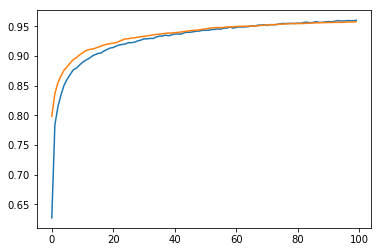

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 5e-05
Learning rate decay: 1e-05
Dropout rate Layer 1:0.1, Layer 2: 0.1
Epoch : 1 Loss : 1.522  Train Accuracy: 0.655 Validation Accuracy: 0.800
Epoch : 2 Loss : 0.910  Train Accuracy: 0.797 Validation Accuracy: 0.837
Epoch : 3 Loss : 0.674  Train Accuracy: 0.829 Validation Accuracy: 0.854
Epoch : 4 Loss : 0.556  Train Accuracy: 0.846 Validation Accuracy: 0.865
Epoch : 5 Loss : 0.490  Train Accuracy: 0.859 Validation Accuracy: 0.876
Epoch : 6 Loss : 0.445  Train Accuracy: 0.870 Validation Accuracy: 0.885
Epoch : 7 Loss : 0.415  Train Accuracy: 0.877 Validation Accuracy: 0.892
Epoch : 8 Loss : 0.394  Train Accuracy: 0.882 Validation Accuracy: 0.895
Epoch : 9 Loss : 0.377  Train Accuracy: 0.887 Validation Accuracy: 0.899
Epoch : 10 Loss : 0.363  Train Accuracy: 0.892 Validation Accuracy: 0.902
Epoch : 11 Loss : 0.351  Train Accuracy: 0.895 Validation Accuracy: 0.904
Epoch : 12 Loss : 0.342  Train Accuracy: 0.898 Validation A

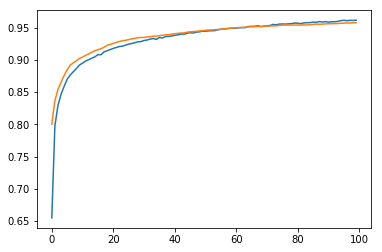

Neural Net Hyper params:
Layers: [784, 750, 500]
Learning Rate: 0.0001
Learning rate decay: 1e-06
Dropout rate Layer 1:0.2, Layer 2: 0.2
Epoch : 1 Loss : 0.821  Train Accuracy: 0.793 Validation Accuracy: 0.882
Epoch : 2 Loss : 0.389  Train Accuracy: 0.885 Validation Accuracy: 0.907
Epoch : 3 Loss : 0.326  Train Accuracy: 0.905 Validation Accuracy: 0.919
Epoch : 4 Loss : 0.279  Train Accuracy: 0.919 Validation Accuracy: 0.932
Epoch : 5 Loss : 0.243  Train Accuracy: 0.928 Validation Accuracy: 0.936
Epoch : 6 Loss : 0.220  Train Accuracy: 0.934 Validation Accuracy: 0.943
Epoch : 7 Loss : 0.196  Train Accuracy: 0.943 Validation Accuracy: 0.946
Epoch : 8 Loss : 0.181  Train Accuracy: 0.946 Validation Accuracy: 0.951
Epoch : 9 Loss : 0.165  Train Accuracy: 0.952 Validation Accuracy: 0.952
Epoch : 10 Loss : 0.153  Train Accuracy: 0.954 Validation Accuracy: 0.955
Epoch : 11 Loss : 0.143  Train Accuracy: 0.957 Validation Accuracy: 0.957
Epoch : 12 Loss : 0.133  Train Accuracy: 0.959 Validation 

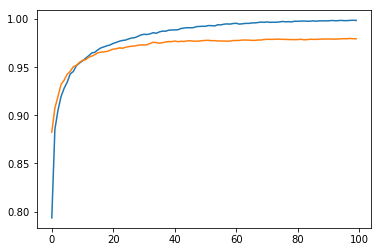

Neural Net Hyper params:
Layers: [784, 750, 500]
Learning Rate: 0.0001
Learning rate decay: 1e-06
Dropout rate Layer 1:0.15, Layer 2: 0.15
Epoch : 1 Loss : 0.803  Train Accuracy: 0.798 Validation Accuracy: 0.883
Epoch : 2 Loss : 0.369  Train Accuracy: 0.891 Validation Accuracy: 0.907
Epoch : 3 Loss : 0.310  Train Accuracy: 0.911 Validation Accuracy: 0.919
Epoch : 4 Loss : 0.274  Train Accuracy: 0.921 Validation Accuracy: 0.933
Epoch : 5 Loss : 0.240  Train Accuracy: 0.930 Validation Accuracy: 0.936
Epoch : 6 Loss : 0.213  Train Accuracy: 0.937 Validation Accuracy: 0.943
Epoch : 7 Loss : 0.194  Train Accuracy: 0.944 Validation Accuracy: 0.946
Epoch : 8 Loss : 0.179  Train Accuracy: 0.947 Validation Accuracy: 0.948
Epoch : 9 Loss : 0.163  Train Accuracy: 0.951 Validation Accuracy: 0.952
Epoch : 10 Loss : 0.150  Train Accuracy: 0.955 Validation Accuracy: 0.954
Epoch : 11 Loss : 0.141  Train Accuracy: 0.957 Validation Accuracy: 0.957
Epoch : 12 Loss : 0.131  Train Accuracy: 0.960 Validatio

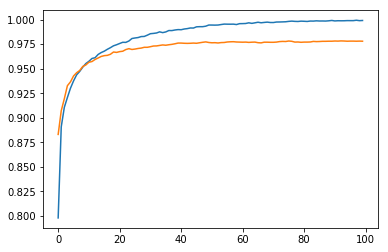

Neural Net Hyper params:
Layers: [784, 750, 500]
Learning Rate: 0.0001
Learning rate decay: 1e-06
Dropout rate Layer 1:0.1, Layer 2: 0.1
Epoch : 1 Loss : 0.789  Train Accuracy: 0.808 Validation Accuracy: 0.885
Epoch : 2 Loss : 0.359  Train Accuracy: 0.894 Validation Accuracy: 0.908
Epoch : 3 Loss : 0.304  Train Accuracy: 0.912 Validation Accuracy: 0.922
Epoch : 4 Loss : 0.266  Train Accuracy: 0.923 Validation Accuracy: 0.932
Epoch : 5 Loss : 0.236  Train Accuracy: 0.931 Validation Accuracy: 0.936
Epoch : 6 Loss : 0.211  Train Accuracy: 0.938 Validation Accuracy: 0.942
Epoch : 7 Loss : 0.191  Train Accuracy: 0.943 Validation Accuracy: 0.944
Epoch : 8 Loss : 0.177  Train Accuracy: 0.948 Validation Accuracy: 0.947
Epoch : 9 Loss : 0.162  Train Accuracy: 0.952 Validation Accuracy: 0.950
Epoch : 10 Loss : 0.149  Train Accuracy: 0.956 Validation Accuracy: 0.953
Epoch : 11 Loss : 0.139  Train Accuracy: 0.959 Validation Accuracy: 0.956
Epoch : 12 Loss : 0.128  Train Accuracy: 0.962 Validation 

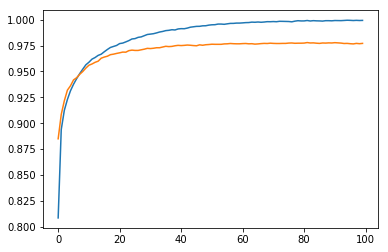

Neural Net Hyper params:
Layers: [784, 750, 500]
Learning Rate: 0.0001
Learning rate decay: 1e-05
Dropout rate Layer 1:0.2, Layer 2: 0.2
Epoch : 1 Loss : 0.819  Train Accuracy: 0.786 Validation Accuracy: 0.885
Epoch : 2 Loss : 0.384  Train Accuracy: 0.884 Validation Accuracy: 0.907
Epoch : 3 Loss : 0.322  Train Accuracy: 0.906 Validation Accuracy: 0.921
Epoch : 4 Loss : 0.276  Train Accuracy: 0.920 Validation Accuracy: 0.931
Epoch : 5 Loss : 0.244  Train Accuracy: 0.927 Validation Accuracy: 0.936
Epoch : 6 Loss : 0.217  Train Accuracy: 0.935 Validation Accuracy: 0.941
Epoch : 7 Loss : 0.199  Train Accuracy: 0.942 Validation Accuracy: 0.945
Epoch : 8 Loss : 0.183  Train Accuracy: 0.947 Validation Accuracy: 0.949
Epoch : 9 Loss : 0.168  Train Accuracy: 0.949 Validation Accuracy: 0.951
Epoch : 10 Loss : 0.156  Train Accuracy: 0.953 Validation Accuracy: 0.954
Epoch : 11 Loss : 0.145  Train Accuracy: 0.956 Validation Accuracy: 0.957
Epoch : 12 Loss : 0.137  Train Accuracy: 0.958 Validation 

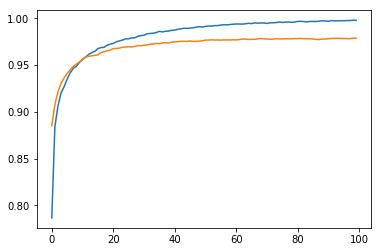

Neural Net Hyper params:
Layers: [784, 750, 500]
Learning Rate: 0.0001
Learning rate decay: 1e-05
Dropout rate Layer 1:0.15, Layer 2: 0.15
Epoch : 1 Loss : 0.804  Train Accuracy: 0.800 Validation Accuracy: 0.881
Epoch : 2 Loss : 0.373  Train Accuracy: 0.888 Validation Accuracy: 0.906
Epoch : 3 Loss : 0.316  Train Accuracy: 0.907 Validation Accuracy: 0.919
Epoch : 4 Loss : 0.273  Train Accuracy: 0.922 Validation Accuracy: 0.931
Epoch : 5 Loss : 0.241  Train Accuracy: 0.929 Validation Accuracy: 0.937
Epoch : 6 Loss : 0.214  Train Accuracy: 0.936 Validation Accuracy: 0.941
Epoch : 7 Loss : 0.197  Train Accuracy: 0.942 Validation Accuracy: 0.945
Epoch : 8 Loss : 0.182  Train Accuracy: 0.946 Validation Accuracy: 0.949
Epoch : 9 Loss : 0.167  Train Accuracy: 0.950 Validation Accuracy: 0.952
Epoch : 10 Loss : 0.156  Train Accuracy: 0.954 Validation Accuracy: 0.955
Epoch : 11 Loss : 0.144  Train Accuracy: 0.957 Validation Accuracy: 0.956
Epoch : 12 Loss : 0.133  Train Accuracy: 0.960 Validatio

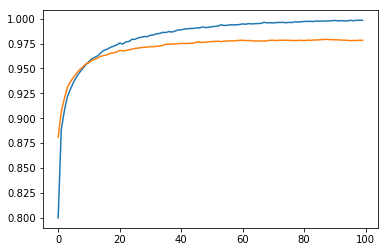

Neural Net Hyper params:
Layers: [784, 750, 500]
Learning Rate: 0.0001
Learning rate decay: 1e-05
Dropout rate Layer 1:0.1, Layer 2: 0.1
Epoch : 1 Loss : 0.750  Train Accuracy: 0.817 Validation Accuracy: 0.889
Epoch : 2 Loss : 0.351  Train Accuracy: 0.896 Validation Accuracy: 0.910
Epoch : 3 Loss : 0.298  Train Accuracy: 0.913 Validation Accuracy: 0.925
Epoch : 4 Loss : 0.259  Train Accuracy: 0.925 Validation Accuracy: 0.930
Epoch : 5 Loss : 0.232  Train Accuracy: 0.932 Validation Accuracy: 0.936
Epoch : 6 Loss : 0.209  Train Accuracy: 0.939 Validation Accuracy: 0.943
Epoch : 7 Loss : 0.190  Train Accuracy: 0.944 Validation Accuracy: 0.948
Epoch : 8 Loss : 0.172  Train Accuracy: 0.950 Validation Accuracy: 0.950
Epoch : 9 Loss : 0.157  Train Accuracy: 0.953 Validation Accuracy: 0.953
Epoch : 10 Loss : 0.147  Train Accuracy: 0.956 Validation Accuracy: 0.955
Epoch : 11 Loss : 0.137  Train Accuracy: 0.960 Validation Accuracy: 0.958
Epoch : 12 Loss : 0.129  Train Accuracy: 0.962 Validation 

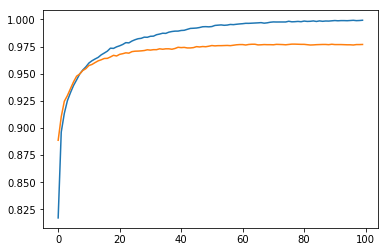

Neural Net Hyper params:
Layers: [784, 750, 500]
Learning Rate: 5e-05
Learning rate decay: 1e-06
Dropout rate Layer 1:0.2, Layer 2: 0.2
Epoch : 1 Loss : 1.314  Train Accuracy: 0.706 Validation Accuracy: 0.839
Epoch : 2 Loss : 0.654  Train Accuracy: 0.832 Validation Accuracy: 0.867
Epoch : 3 Loss : 0.485  Train Accuracy: 0.858 Validation Accuracy: 0.884
Epoch : 4 Loss : 0.421  Train Accuracy: 0.873 Validation Accuracy: 0.894
Epoch : 5 Loss : 0.386  Train Accuracy: 0.885 Validation Accuracy: 0.900
Epoch : 6 Loss : 0.361  Train Accuracy: 0.892 Validation Accuracy: 0.906
Epoch : 7 Loss : 0.338  Train Accuracy: 0.900 Validation Accuracy: 0.911
Epoch : 8 Loss : 0.323  Train Accuracy: 0.906 Validation Accuracy: 0.915
Epoch : 9 Loss : 0.308  Train Accuracy: 0.910 Validation Accuracy: 0.919
Epoch : 10 Loss : 0.294  Train Accuracy: 0.915 Validation Accuracy: 0.922
Epoch : 11 Loss : 0.283  Train Accuracy: 0.917 Validation Accuracy: 0.926
Epoch : 12 Loss : 0.269  Train Accuracy: 0.922 Validation A

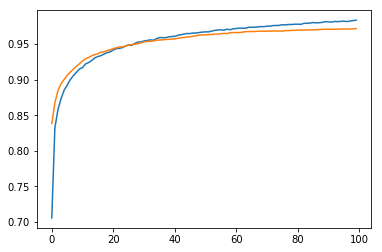

Neural Net Hyper params:
Layers: [784, 750, 500]
Learning Rate: 5e-05
Learning rate decay: 1e-06
Dropout rate Layer 1:0.15, Layer 2: 0.15
Epoch : 1 Loss : 1.303  Train Accuracy: 0.720 Validation Accuracy: 0.835
Epoch : 2 Loss : 0.647  Train Accuracy: 0.837 Validation Accuracy: 0.865
Epoch : 3 Loss : 0.476  Train Accuracy: 0.865 Validation Accuracy: 0.882
Epoch : 4 Loss : 0.409  Train Accuracy: 0.879 Validation Accuracy: 0.891
Epoch : 5 Loss : 0.372  Train Accuracy: 0.890 Validation Accuracy: 0.898
Epoch : 6 Loss : 0.349  Train Accuracy: 0.897 Validation Accuracy: 0.904
Epoch : 7 Loss : 0.332  Train Accuracy: 0.902 Validation Accuracy: 0.908
Epoch : 8 Loss : 0.318  Train Accuracy: 0.907 Validation Accuracy: 0.913
Epoch : 9 Loss : 0.303  Train Accuracy: 0.911 Validation Accuracy: 0.916
Epoch : 10 Loss : 0.292  Train Accuracy: 0.914 Validation Accuracy: 0.920
Epoch : 11 Loss : 0.280  Train Accuracy: 0.918 Validation Accuracy: 0.925
Epoch : 12 Loss : 0.270  Train Accuracy: 0.923 Validation

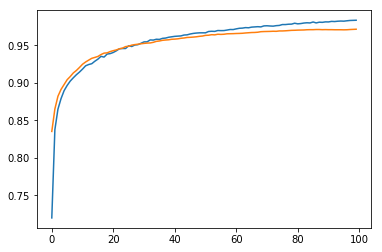

Neural Net Hyper params:
Layers: [784, 750, 500]
Learning Rate: 5e-05
Learning rate decay: 1e-06
Dropout rate Layer 1:0.1, Layer 2: 0.1
Epoch : 1 Loss : 1.268  Train Accuracy: 0.736 Validation Accuracy: 0.832
Epoch : 2 Loss : 0.612  Train Accuracy: 0.847 Validation Accuracy: 0.869
Epoch : 3 Loss : 0.450  Train Accuracy: 0.873 Validation Accuracy: 0.888
Epoch : 4 Loss : 0.384  Train Accuracy: 0.886 Validation Accuracy: 0.895
Epoch : 5 Loss : 0.352  Train Accuracy: 0.897 Validation Accuracy: 0.901
Epoch : 6 Loss : 0.331  Train Accuracy: 0.902 Validation Accuracy: 0.906
Epoch : 7 Loss : 0.318  Train Accuracy: 0.907 Validation Accuracy: 0.912
Epoch : 8 Loss : 0.304  Train Accuracy: 0.911 Validation Accuracy: 0.916
Epoch : 9 Loss : 0.290  Train Accuracy: 0.915 Validation Accuracy: 0.921
Epoch : 10 Loss : 0.281  Train Accuracy: 0.919 Validation Accuracy: 0.924
Epoch : 11 Loss : 0.271  Train Accuracy: 0.921 Validation Accuracy: 0.927
Epoch : 12 Loss : 0.259  Train Accuracy: 0.925 Validation A

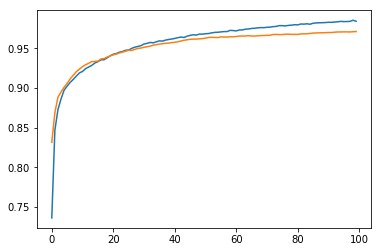

Neural Net Hyper params:
Layers: [784, 750, 500]
Learning Rate: 5e-05
Learning rate decay: 1e-05
Dropout rate Layer 1:0.2, Layer 2: 0.2
Epoch : 1 Loss : 1.324  Train Accuracy: 0.696 Validation Accuracy: 0.836
Epoch : 2 Loss : 0.664  Train Accuracy: 0.827 Validation Accuracy: 0.866
Epoch : 3 Loss : 0.493  Train Accuracy: 0.859 Validation Accuracy: 0.883
Epoch : 4 Loss : 0.421  Train Accuracy: 0.874 Validation Accuracy: 0.893
Epoch : 5 Loss : 0.385  Train Accuracy: 0.884 Validation Accuracy: 0.899
Epoch : 6 Loss : 0.362  Train Accuracy: 0.892 Validation Accuracy: 0.906
Epoch : 7 Loss : 0.348  Train Accuracy: 0.896 Validation Accuracy: 0.910
Epoch : 8 Loss : 0.331  Train Accuracy: 0.902 Validation Accuracy: 0.914
Epoch : 9 Loss : 0.314  Train Accuracy: 0.908 Validation Accuracy: 0.916
Epoch : 10 Loss : 0.302  Train Accuracy: 0.912 Validation Accuracy: 0.919
Epoch : 11 Loss : 0.288  Train Accuracy: 0.915 Validation Accuracy: 0.925
Epoch : 12 Loss : 0.277  Train Accuracy: 0.919 Validation A

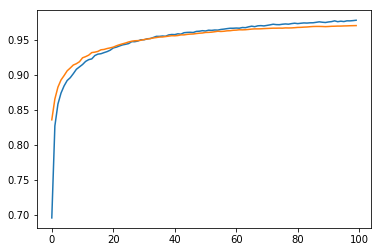

Neural Net Hyper params:
Layers: [784, 750, 500]
Learning Rate: 5e-05
Learning rate decay: 1e-05
Dropout rate Layer 1:0.15, Layer 2: 0.15
Epoch : 1 Loss : 1.311  Train Accuracy: 0.717 Validation Accuracy: 0.839
Epoch : 2 Loss : 0.637  Train Accuracy: 0.840 Validation Accuracy: 0.868
Epoch : 3 Loss : 0.469  Train Accuracy: 0.866 Validation Accuracy: 0.884
Epoch : 4 Loss : 0.404  Train Accuracy: 0.881 Validation Accuracy: 0.893
Epoch : 5 Loss : 0.370  Train Accuracy: 0.889 Validation Accuracy: 0.899
Epoch : 6 Loss : 0.349  Train Accuracy: 0.897 Validation Accuracy: 0.904
Epoch : 7 Loss : 0.333  Train Accuracy: 0.903 Validation Accuracy: 0.908
Epoch : 8 Loss : 0.316  Train Accuracy: 0.908 Validation Accuracy: 0.913
Epoch : 9 Loss : 0.305  Train Accuracy: 0.912 Validation Accuracy: 0.917
Epoch : 10 Loss : 0.293  Train Accuracy: 0.915 Validation Accuracy: 0.920
Epoch : 11 Loss : 0.284  Train Accuracy: 0.918 Validation Accuracy: 0.923
Epoch : 12 Loss : 0.274  Train Accuracy: 0.921 Validation

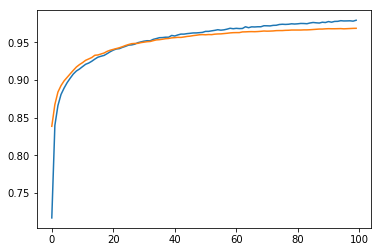

Neural Net Hyper params:
Layers: [784, 750, 500]
Learning Rate: 5e-05
Learning rate decay: 1e-05
Dropout rate Layer 1:0.1, Layer 2: 0.1
Epoch : 1 Loss : 1.263  Train Accuracy: 0.737 Validation Accuracy: 0.836
Epoch : 2 Loss : 0.616  Train Accuracy: 0.845 Validation Accuracy: 0.868
Epoch : 3 Loss : 0.454  Train Accuracy: 0.871 Validation Accuracy: 0.884
Epoch : 4 Loss : 0.388  Train Accuracy: 0.886 Validation Accuracy: 0.893
Epoch : 5 Loss : 0.355  Train Accuracy: 0.896 Validation Accuracy: 0.902
Epoch : 6 Loss : 0.336  Train Accuracy: 0.902 Validation Accuracy: 0.906
Epoch : 7 Loss : 0.318  Train Accuracy: 0.908 Validation Accuracy: 0.912
Epoch : 8 Loss : 0.301  Train Accuracy: 0.913 Validation Accuracy: 0.916
Epoch : 9 Loss : 0.288  Train Accuracy: 0.917 Validation Accuracy: 0.921
Epoch : 10 Loss : 0.283  Train Accuracy: 0.919 Validation Accuracy: 0.925
Epoch : 11 Loss : 0.271  Train Accuracy: 0.922 Validation Accuracy: 0.928
Epoch : 12 Loss : 0.263  Train Accuracy: 0.924 Validation A

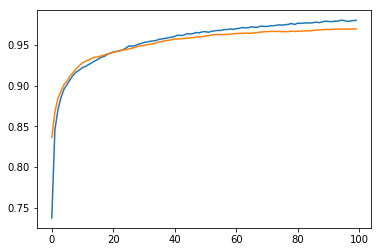

In [67]:
#Hyper parameter search

hparams = {
    "layers": [[28*28,500,250], [28*28,750,500]],
    "lr": [10e-5,5e-5],
    "lr_decay": [10e-7,10e-6],
    "dropout": [[0.2,0.2],[0.15,0.15],[0.1,0.1]]
}

bestModel = hyperparamsearch(100, hparams, trainloader, validloader)
                



## Doubling the number of parameters
Currently there are: (784+(784*750) + 750+(750*500)+ (500*10)+500)+ 10) = 970,044 parameters
(in_size+(in_size*size1) + size1 + (size1*size2) + size2 + (size2*outsize) + outsize

We would like to create a new model with twice as many parameters, 1,940,088 parameters.




In [ ]:
layers = list(bestModel.parameters())
print bestValAcc
print bestModel

In [ ]:
layerDims = [784,1.6*750,1.6*500]
lr=0.0001
lr_decay = 1e-06
dropout = [0.1,0.1]

Double_NN = MLP_MNIST(layerDims,10,dropout)
params = list(NN.parameters())
summy = 0 
for p in params:
    print p.size()
    if len(p.size()) > 1:
        summy += p.size()[0]*p.size()[1]
    else:
        summy += p.size()[0]
print summy

In [ ]:
layerDims = [784,int(1.6*750),int(1.6*500)]
lr=0.00001
lr_decay = 1e-06
dropout = [0.1,0.1]

Double_NN = GlorotInitialize(Double_NN)
optimizer = torch.optim.SGD(Double_NN.parameters(), lr=lr,lr_decay = decay)
(Double_NN, epoch_loss, train_accuracy, val_accuracy) = train(Double_NN,100,trainloader,optimizer,validloader,testloader)

        


# Training Set Size, Generalization Gap, and Standard Error

First we'll randomly sample subsets of the training data


In [ ]:
alphas = [0.01,0.02,0.05,0.1,1.0]
TRAINSIZE = 50000
indices = list(range(TRAINSIZE))
val_percent = 0.2


train_idx, valid_idx = indices[split:], indices[:split]

#Hyperparameters for model
layerDims = [784,750,500]
lr=0.00001
lr_decay = 1e-06
dropout = [0.1,0.1]


for alpha in alphas:
    train_subset = np.random.choice(indices,size=[int(alpha*TRAINSIZE)])
    split = int((1-val_percent)*len(train_subset))
    sub_train_idx, sub_valid_idx = train_subset[:split], train_subset[split:]
    
    sub_train_sampler = torch.utils.data.sampler.SubsetRandomSampler(sub_train_idx)
    sub_valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(sub_valid_idx)

    
    subtrainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, sampler=sub_train_sampler, num_workers=2)
    subvalidloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, sampler=sub_valid_sampler, num_workers=2)
    Model = MLP_MNIST(layerDims,lr,dropout)
    optimizer = 
    

# Problem 2

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import scale
from sklearn.neural_network import MLPClassifier
train_dataset = fetch_20newsgroups(subset='train')
test_dataset = fetch_20newsgroups(subset='test')
MAXFEATS = 30000

In [2]:
count_vectorizer = CountVectorizer(max_features=MAXFEATS,stop_words='english')
count_vectorizer.fit(train_dataset.data)
train_counts = count_vectorizer.transform(train_dataset.data)
#test_counts = count_vectorizer.transform(test_dataset.data)

print train_counts.shape
print type(train_counts)

(11314, 30000)
<class 'scipy.sparse.csr.csr_matrix'>


In [4]:
def normalize_data(data):
    #data = data.todense()
    #s = StandardScaler()
    #s.fit(data)
    #s.var_ += 1e-5
    #normalized_data = s.transform(data)
    #variance =  np.var(data,axis=1)
    #variance += 1e-5
    #print variance.shape
    #data = data - np.mean(data,axis=1)[:,None]
    #normalized_data = np.divide((data),(variance[:,None]))
    mean = data.mean(axis=1)
    print mean.shape
    data = data - mean
    normalized_data = scale(data,axis=1)
    print normalized_data.mean
    return normalized_data

n = normalize_data(train_counts)


(11314, 1)
<built-in method mean of numpy.ndarray object at 0x7f2c6cf105d0>


In [ ]:
class MLP_20(nn.Module):
    
    def __init__(self,insize,outsize,dropout=0):
        super(MLP_20,self).__init__()
        self.fc1 = nn.Linear(insize,100)
        self.dropout1 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(100,outsize)
        self.insize = insize
        
    def forward(self,x):
        a1 = self.fc1(x)
        d1 = self.dropout1(a1)
        h1 = nn.functional.relu(d1)
        
        logits = self.fc2(h1)
        
        return logits
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices

    

In [ ]:
#Convert to sparse matrix
#train_counts_coo = train_counts.tocoo()
#locs = torch.LongTensor([train_counts_coo.row.astype(int),train_counts_coo.col.astype(int)])
#dat = torch.FloatTensor(train_counts_coo.data)
#inputs_tensor = torch.sparse.FloatTensor(locs,dat, torch.Size([11314,130107]))
NN_20 = MLP_20(60000,20)
NN_20 = GlorotInitialize(NN_20)
inputs_tensor = torch.Tensor(train_counts.todense())
#t = torch.from_numpy(train_counts_coo)
train_tensor = torch.utils.data.TensorDataset(inputs_tensor,torch.IntTensor(train_dataset.target))



In [ ]:
train_loader_newsgroups = torch.utils.data.DataLoader(train_tensor,batch_size=10, shuffle = False)
optimizer = torch.optim.SGD(NN_20.parameters(), lr=1e-7,momentum=0.9)
loss_crit = nn.CrossEntropyLoss()
train_results = train(NN_20,20,train_loader_newsgroups,optimizer)

In [ ]:
MAXFEATS=60000
tfidfVectorizer = TfidfVectorizer(max_features=MAXFEATS,stop_words='english')

train_tfidfCounts = tfidfVectorizer.fit_transform(train_dataset.data)

inputs_tensor_tfidf = torch.Tensor(train_tfidfCounts.todense())
tfidf_train_tensor = torch.utils.data.TensorDataset(inputs_tensor_tfidf,torch.IntTensor(train_dataset.target))


In [ ]:
print train_dataset.target[0]
print train_dataset.data[0]
print train_tfidfCounts.shape

In [ ]:
train_loader_newsgroups_tfidf = torch.utils.data.DataLoader(tfidf_train_tensor,batch_size=128, shuffle = False)
optimizer = torch.optim.SGD(NN_20.parameters(), lr=1e-4,momentum=0.9)
loss_crit = nn.CrossEntropyLoss()

In [ ]:
lrs = [1e-3,1e-4,1e-5,1e-6,1e-7]
models = [0]*len(lrs)
for i,lr in enumerate(lrs):
    models[i] = MLP_20(MAXFEATS,20)
    models[i] = GlorotInitialize(models[i])
    optimizer = torch.optim.SGD(models[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_res = train(models[i],20,train_loader_newsgroups_tfidf,optimizer)

In [ ]:
### Standardized preprocessing
normalized_train_counts = normalize_data(train_counts)
train_standard = torch.Tensor(normalized_train_counts)
train_standard_tensor = torch.utils.data.TensorDataset(train_standard,torch.IntTensor(train_dataset.target))
normalized_test = normalize_data(test_counts)
test_standard_tensor = torch.utils.data.TensorDataset(torch.Tensor(normalized_test, torch.IntTensor(test_dataset.target)))

train_loader_ng_standard = torch.utils.data.DataLoader(train_standard_tensor,batch_size=128, shuffle = True)
test_loader_ng_standard = torch.utils.data.DataLoader(test_standard_tensor,batch_size=128)


In [ ]:
lrs = [1e-4,1e-5,1e-6,1e-7]
models_standard = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models_standard[i] = MLP_20(MAXFEATS,20)
    models_standard[i] = GlorotInitialize(models_standard[i])
    optimizer = torch.optim.SGD(models_standard[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_res = train(models_standard[i],20,train_loader_ng_standard,optimizer)
    